#Q1-Plot the converged policy and value function for this grid world.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math

In [2]:
class GridWorld:
    def __init__(self, size, goal_state, obstacle_states, terminal_states):
        self.size = size
        self.goal = goal_state
        self.obstacles = obstacle_states
        self.terminals = terminal_states
        self.state = None

    def reset(self):
        self.state = [1, 1]  # Start state

    def step(self, action):

        current_state = self.state

        if action == 'N':
            next_state = [self.state[0] - 1, self.state[1]]
        elif action == 'S':
            next_state = [self.state[0] + 1, self.state[1]]
        elif action == 'E':
            next_state = [self.state[0], self.state[1] + 1]
        elif action == 'W':
            next_state = [self.state[0], self.state[1] - 1]
        else:
            raise ValueError("Invalid action")

        # Check if the next state is valid
        if self.is_valid_state(next_state):
            self.state = next_state
            reward = self.get_reward(self.state)
        else:
            reward = self.get_reward(next_state)

        is_goal = self.is_goal_state(self.state)



        return self.state, reward, is_goal

    def is_valid_state(self, state):
        # Check if the state is within the grid boundaries and not an obstacle or terminal state
        if (1 <= state[0] <= self.size) and (1 <= state[1] <= self.size) and (state not in self.obstacles) and (state not in self.terminals):
            return True
        return False

    def is_goal_state(self, state):
        # Check if the state is the goal state
        if state == self.goal:
            return True
        return False

    def get_reward(self, state):
        # Return the reward for the given state
        if state == self.goal:
            return 5  # Goal reward
        elif state == self.terminals:
            return -5 # terminal reward
        elif (state[0] < 1) or (state[1] < 1) or (state[0] > self.size) or (state[1] > self.size):
            return -1 # Out of Bounds reward
        else:
            return 0

    def plot_grid(self, policy=None, plot_policy_flag=False):
        plt.figure()
        ax = plt.gca()

        # Plot gridlines
        for i in range(1, self.size):
            ax.axhline(i, color='k', linestyle='-', linewidth=1)
            ax.axvline(i, color='k', linestyle='-', linewidth=1)

        # Plot goal state
        ax.plot(self.goal[1] - 0.5, self.goal[0] - 0.5, 'gs', markerfacecolor='g', markersize=30)

        # Plot obstacles
        for obstacle in self.obstacles:
            ax.plot(obstacle[1] - 0.5, obstacle[0] - 0.5, 'ks', markerfacecolor='k', markersize=30)

        # Plot terminals
        for terminal in self.terminals:
            ax.plot(terminal[1] - 0.5, terminal[0] - 0.5, 'rs', markerfacecolor='r', markersize=30)

        # Plot current state
        ax.plot(self.state[1] - 0.5, self.state[0] - 0.5, 'ro', markerfacecolor='r', markersize=20)

        if plot_policy_flag and policy is not None:
            self.plot_policy_arrows(policy)

        ax.set_xlim([0, self.size])
        ax.set_ylim([self.size, 0])
        ax.set_xticks(np.arange(self.size))
        ax.set_yticks(np.arange(self.size))
        ax.grid(True)
        ax.set_aspect('equal')
        plt.show()

    def plot_policy_arrows(self, policy):
        for i in range(self.size):
            for j in range(self.size):
                if [i + 1, j + 1] != self.goal and [i + 1, j + 1] not in self.obstacles and [i + 1, j + 1] not in self.terminals:
                    action = policy[i, j]
                    if action == 0:  # North
                        dx, dy = 0, -0.3
                    elif action == 1:  # South
                        dx, dy = 0, 0.3
                    elif action == 2:  # East
                        dx, dy = 0.3, 0
                    elif action == 3:  # West
                        dx, dy = -0.3, 0
                    else:
                        continue

                    plt.arrow(j + 0.5, i + 0.5, dx, dy, head_width=0.1, head_length=0.1, fc='k', ec='k')
                    plt.title('Converged Policy')

In [3]:
def continuous_learning(discount_factor_v,epsilon_v):

  # Define the size of the grid world
  n = 5

  # Define the goal state and reward
  goal_state = [n, n]
  goal_reward = 5

  # Define the obstacle states
  obstacle_states = [[2, 3], [3, 3], [5,3]]

  # Define the terminal state
  terminal_states = [[3,5]]

  # Create an instance of the GridWorld class
  env = GridWorld(n, goal_state, obstacle_states, terminal_states)

  # Set the parameters
  num_episodes = 100000      # Number of episodes for training
  max_steps = n * n * 10     # Maximum number of steps per episode
  learning_rate = 0.1        # Learning rate
  discount_factor = discount_factor_v    # Discount factor (gamma)
  epsilon = epsilon_v        # Exploration rate (epsilon-greedy policy)

  np.random.seed(1) # For reproducibility

  # Initialize the Q-table
  num_actions = 4                  # Number of possible actions (North, South, East, West)
  num_states = env.size * env.size  # Number of states in the grid world
  Q = 0.001 * np.random.rand(num_states, num_actions)  # Q-table

  # Helper function to convert state coordinates to a scalar state representation
  def get_state(coordinates, grid_size):
      return (coordinates[0] - 1) * grid_size + coordinates[1]

  # Perform Q-learning
  episodes = []
  steps = []
  for episode in range(num_episodes):
      # Reset the environment for each episode
      env.reset()
      current_state = get_state(env.state, env.size)

      # Run the episode until a goal state is reached
      for step in range(max_steps):
          # Choose an action using epsilon-greedy policy
          if np.random.rand() < epsilon:
              action_idx = np.random.randint(num_actions)  # Random action
          else:
              action_idx = np.argmax(Q[current_state-1, :])  # Greedy action

          if action_idx == 0:
              action = 'N'
          elif action_idx == 1:
              action = 'S'
          elif action_idx == 2:
              action = 'E'
          else:
              action = 'W'


          # Take a step in the environment
          next_state, reward, is_goal = env.step(action)
          next_state = get_state(next_state, env.size)


          # Update the Q-table using Q-learning update rule
          Q[current_state-1, action_idx] += learning_rate * (
                  reward + discount_factor * np.max(Q[next_state-1, :]) - Q[current_state-1, action_idx])

          # Update the current state
          current_state = next_state

          # Check if a goal state is reached
          if is_goal:
              break

      episodes.append(episode)
      steps.append(step)

  # Compute the converged policy and value function
  policy = np.zeros((env.size, env.size), dtype=int)  # Converged policy
  value_function = np.zeros((env.size, env.size))  # Converged value function

  for i in range(env.size):
      for j in range(env.size):
          state = get_state([i + 1, j + 1], env.size)
          best_action = np.argmax(Q[state-1, :])
          policy[i, j] = best_action
          value_function[i, j] = np.max(Q[state-1, :])
          if [i + 1, j + 1] == env.goal:
              value_function[i, j] = goal_reward

  # Plot the converged policy and value function
  env.plot_grid(policy, plot_policy_flag=True)

  plt.figure()
  plt.imshow(value_function, cmap='hot', interpolation='nearest')
  plt.colorbar()
  plt.title('Converged Value Function')
  plt.xlabel('Columns')
  plt.ylabel('Rows')
  plt.xticks(np.arange(env.size))
  plt.yticks(np.arange(env.size))
  plt.grid(True)
  plt.show()

  return episodes,steps

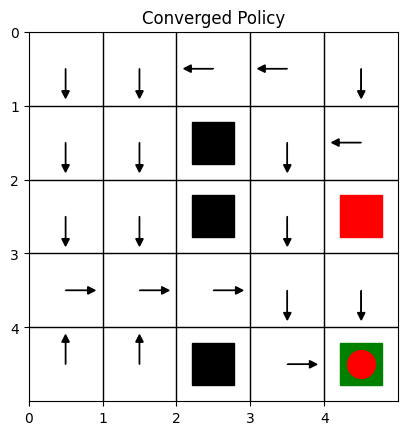

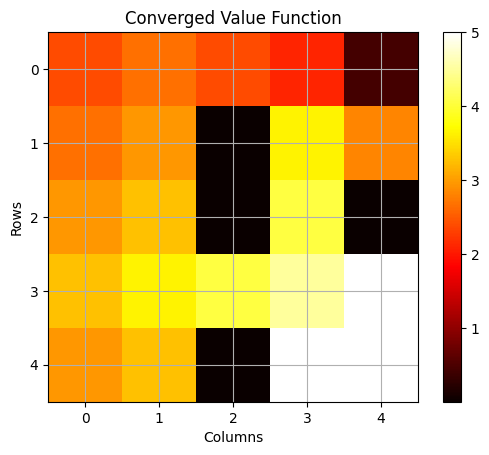

In [4]:
# For gamma = 0.9, epsilon = 0.2
episodes,steps = continuous_learning(0.9,0.2)

In [5]:
# whos

In [6]:
# state = [2,6]
# env.reset()
# print(policy)
# print(env.get_reward(state))

#Q2-Do it for gamma = 0.1, 0.5 and 0.9, take epsilon = 0.1.

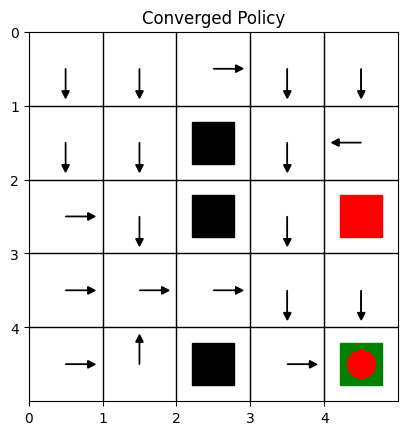

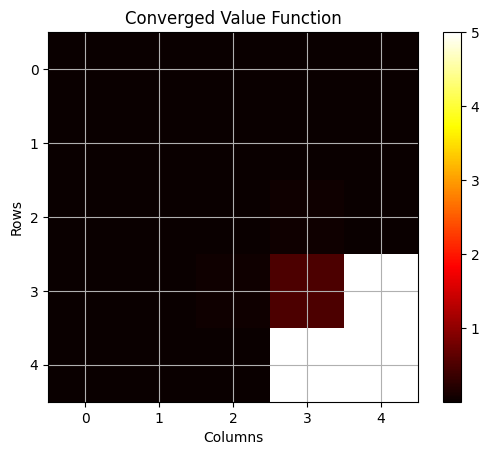

In [7]:
# For gamma = 0.1, epsilon = 0.1
episodes,steps = continuous_learning(0.1,0.1)

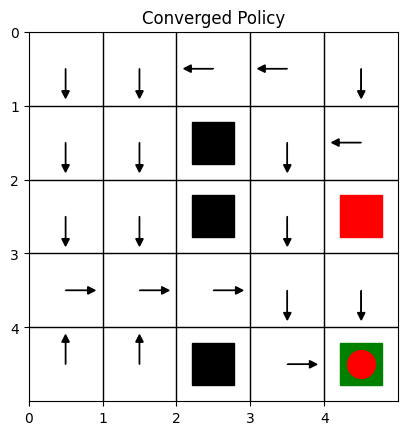

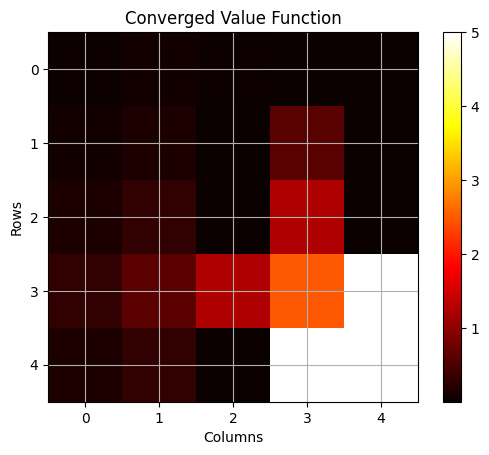

In [8]:
# For gamma = 0.5, epsilon = 0.1
episodes,steps = continuous_learning(0.5,0.1)

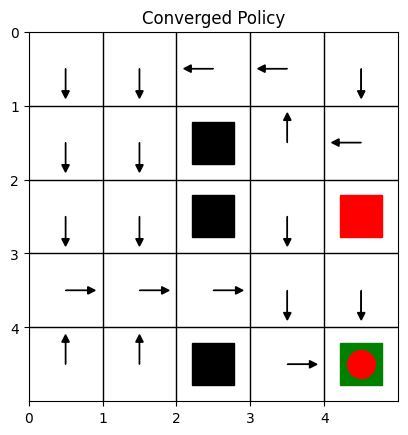

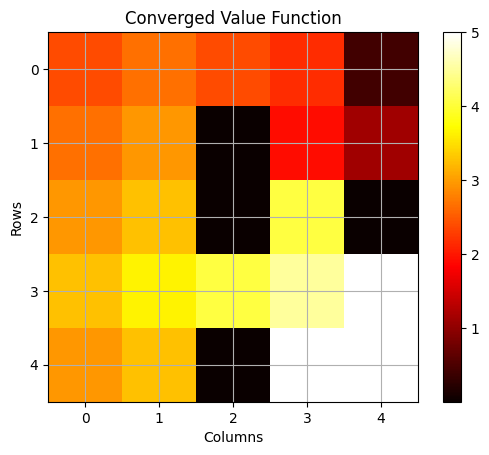

In [9]:
# For gamma = 0.1, epsilon = 0.1
episodes,steps = continuous_learning(0.9,0.1)

#Q3-For gamma = 0.9, plot the no. of steps to reach the goal across episodes for epsilon = 0.1, 0.3 and 0.5.

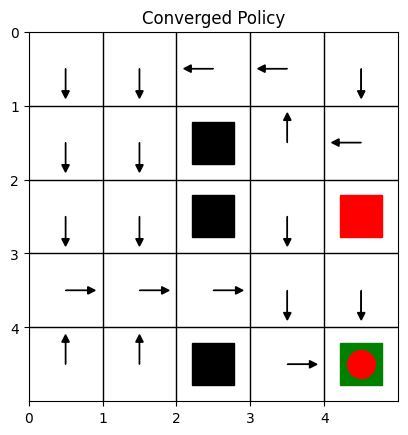

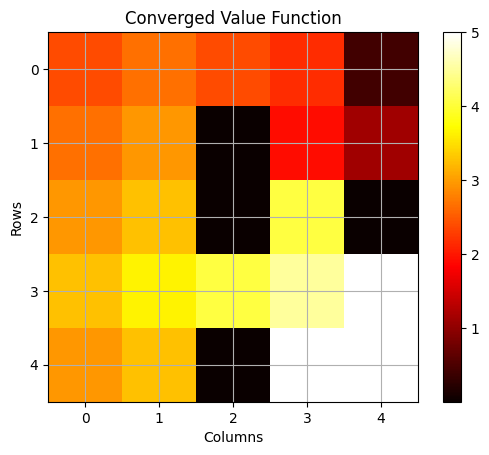

In [10]:
# For gamma = 0.9, epsilon = 0.1
episodes,steps = continuous_learning(0.9,0.1)

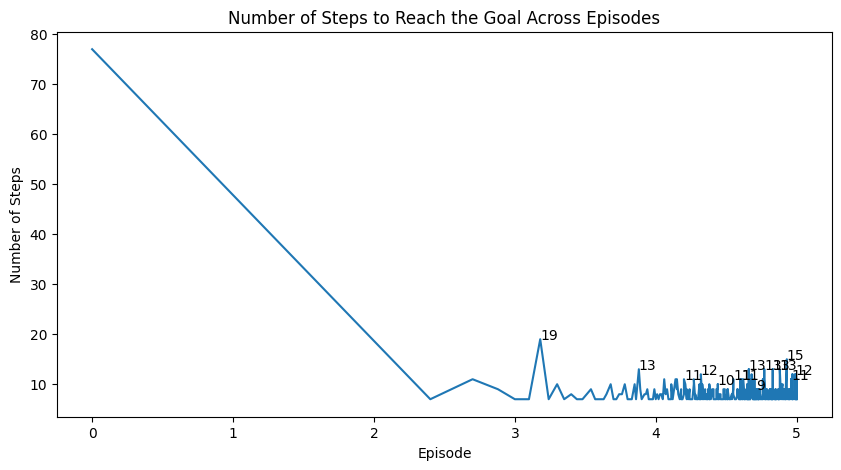

In [11]:
plt.figure(figsize=(10, 5))

# log scaling
episodes = [round(math.log10(i), 2) if i > 0 else 0 for i in episodes]

# Select every 250th data point
episodes = episodes[::250]
steps = steps[::250]

# Create the plot
plt.plot(episodes, steps)

# Add title and labels
plt.title('Number of Steps to Reach the Goal Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')

# Find peaks (you might need to adjust the distance parameter)
peaks, _ = find_peaks(steps, distance=20)

# Annotate peaks
for peak in peaks:
    plt.text(episodes[peak], steps[peak], f'{steps[peak]}')

# Show the plot
plt.show()

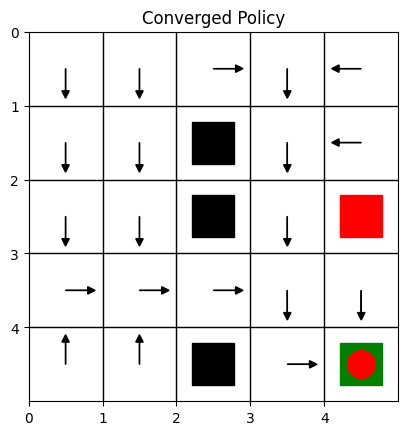

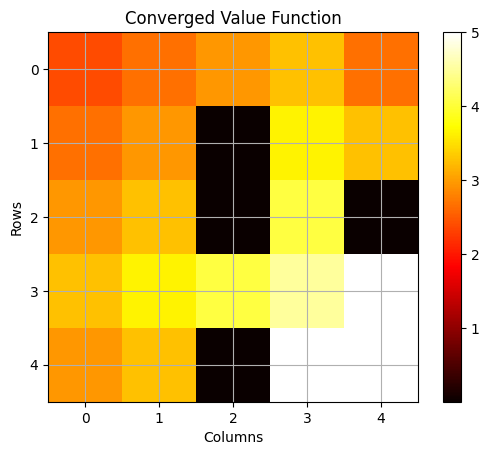

In [12]:
# For gamma = 0.9, epsilon = 0.3
episodes,steps = continuous_learning(0.9,0.3)

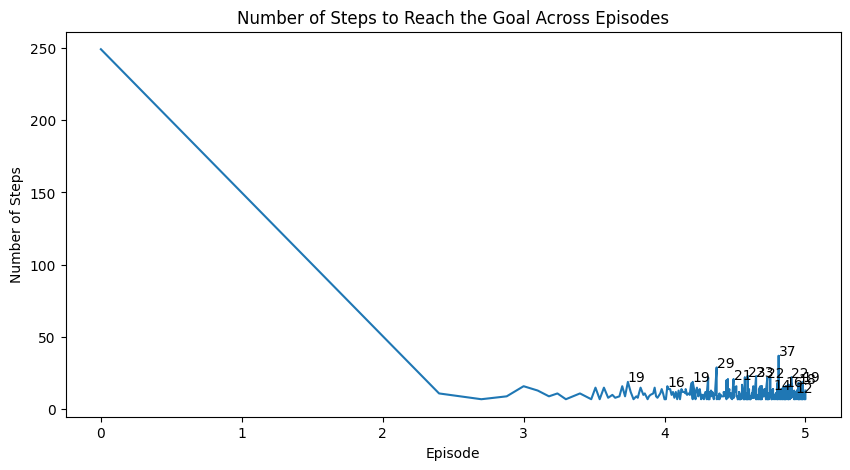

In [13]:
plt.figure(figsize=(10, 5))

# log scaling
episodes = [round(math.log10(i), 2) if i > 0 else 0 for i in episodes]

# Select every 250th data point
episodes = episodes[::250]
steps = steps[::250]

# Create the plot
plt.plot(episodes, steps)

# Add title and labels
plt.title('Number of Steps to Reach the Goal Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')

# Find peaks (you might need to adjust the distance parameter)
peaks, _ = find_peaks(steps, distance=20)

# Annotate peaks
for peak in peaks:
    plt.text(episodes[peak], steps[peak], f'{steps[peak]}')

# Show the plot
plt.show()

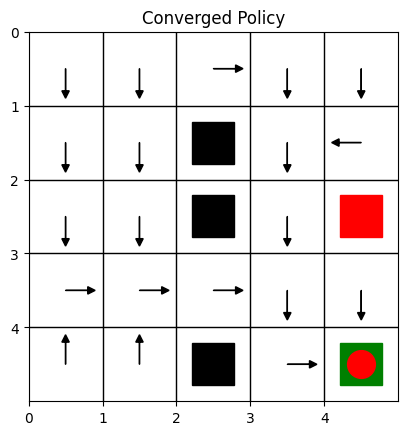

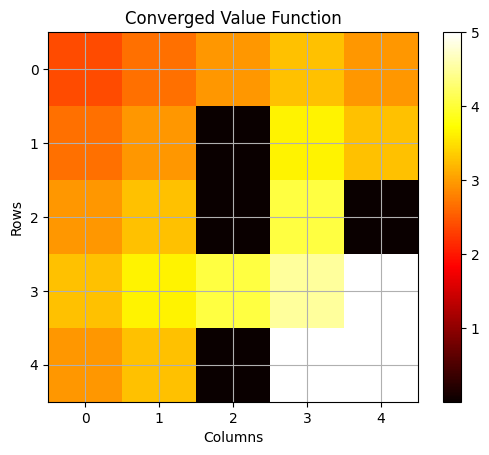

In [14]:
# For gamma = 0.9, epsilon = 0.5
episodes,steps = continuous_learning(0.9,0.5)

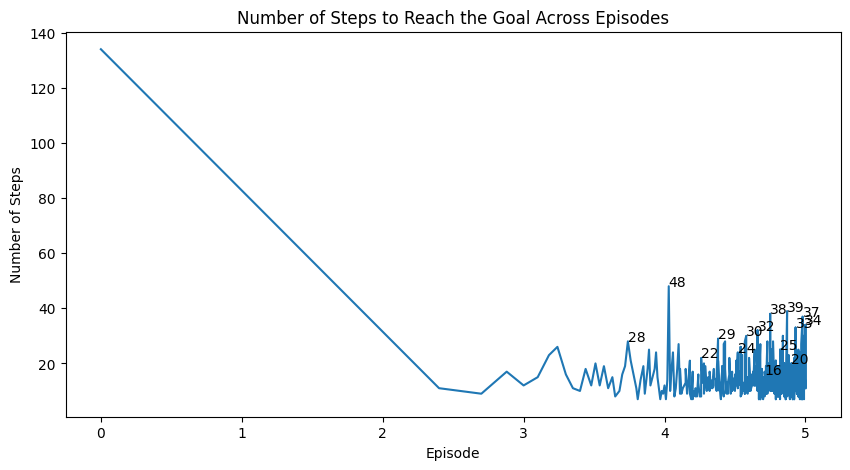

In [15]:
plt.figure(figsize=(10, 5))

# log scaling
episodes = [round(math.log10(i), 2) if i > 0 else 0 for i in episodes]

# Select every 250th data point
episodes = episodes[::250]
steps = steps[::250]

# Create the plot
plt.plot(episodes, steps)

# Add title and labels
plt.title('Number of Steps to Reach the Goal Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')

# Find peaks (you might need to adjust the distance parameter)
peaks, _ = find_peaks(steps, distance=20)

# Annotate peaks
for peak in peaks:
    plt.text(episodes[peak], steps[peak], f'{steps[peak]}')

# Show the plot
plt.show()